# Inflation, Sentiment & Retail Activity in the EA7

This notebook studies how retail activity (RTI) relates to:
- **Inflation** (HICP index)
- **Consumer sentiment** (CCI)

Main questions:
1. Is higher inflation associated with lower retail activity?
2. Does sentiment lead retail activity (predictive content)?
3. Are relationships stable over time (rolling correlations)?
4. Do results hold after controlling for country fixed effects?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")

In [2]:
df = pd.read_csv("../data/processed/macro_panel.csv")

df["month_dt"] = pd.to_datetime(df["month"])
df = df.sort_values(["country", "month_dt"]).reset_index(drop=True)

df[["country","month","rti_index","hicp_index","cci"]].head()

,country,month,rti_index,hicp_index,cci
0,AT,2010-01,99.5,108.12,-4.9
1,AT,2010-02,100.7,108.34,-4.6
2,AT,2010-03,100.7,109.46,-8.6
3,AT,2010-04,99.9,109.69,-5.8
4,AT,2010-05,99.4,109.63,-9.9


## Data note: HFCE is missing

In the current `macro_panel.csv`, **hfce is 100% missing**.
This means HFCE did not successfully merge into the panel (likely because the
Eurostat HFCE dataset uses a different structure/dimensions than expected).

For now:
- we exclude HFCE from analysis,
- and focus on RTI, HICP, and CCI (which are essentially complete).

Later, HFCE can be fixed and added as an extension.

In [3]:
# RTI monthly growth (%)
df["rti_mom"] = df.groupby("country")["rti_index"].pct_change() * 100

# HICP YoY inflation proxy (%): (index / index_12m_ago - 1)*100
df["hicp_yoy"] = (
    df.groupby("country")["hicp_index"]
      .pct_change(12) * 100
)

# Optional: standardize CCI within country (helps comparability)
df["cci_z"] = (
    df["cci"] - df.groupby("country")["cci"].transform("mean")
) / df.groupby("country")["cci"].transform("std")

In [4]:
df[["rti_mom","hicp_yoy","cci","cci_z"]].describe()

,rti_mom,hicp_yoy,cci,cci_z
count,1169.000000,1092.000000,1175.000000,1.175000e+03
mean,0.097372,2.285180,-10.410128,-8.466041e-17
std,3.071378,2.555173,8.958439,9.974414e-01
min,-23.529412,-1.457286,-40.500000,-3.662545e+00
25%,-0.661626,0.733232,-16.400000,-6.819453e-01
50%,0.096525,1.630057,-9.200000,1.339634e-01
75%,0.833333,2.859218,-3.550000,7.598034e-01
max,37.627551,17.065984,7.000000,2.594279e+00


In [5]:
ea7 = (
    df.groupby("month_dt", as_index=False)
      .agg(
          ea7_rti=("rti_index", "mean"),
          ea7_rti_mom=("rti_mom", "mean"),
          ea7_hicp_yoy=("hicp_yoy", "mean"),
          ea7_cci=("cci", "mean"),
      )
)
ea7.head()

,month_dt,ea7_rti,ea7_rti_mom,ea7_hicp_yoy,ea7_cci
0,2010-01-01,100.357143,NaN,NaN,-7.742857
1,2010-02-01,100.585714,0.301836,NaN,-9.128571
2,2010-03-01,101.457143,0.864286,NaN,-9.928571
3,2010-04-01,100.742857,-0.663165,NaN,-9.471429
4,2010-05-01,101.128571,0.402346,NaN,-12.171429


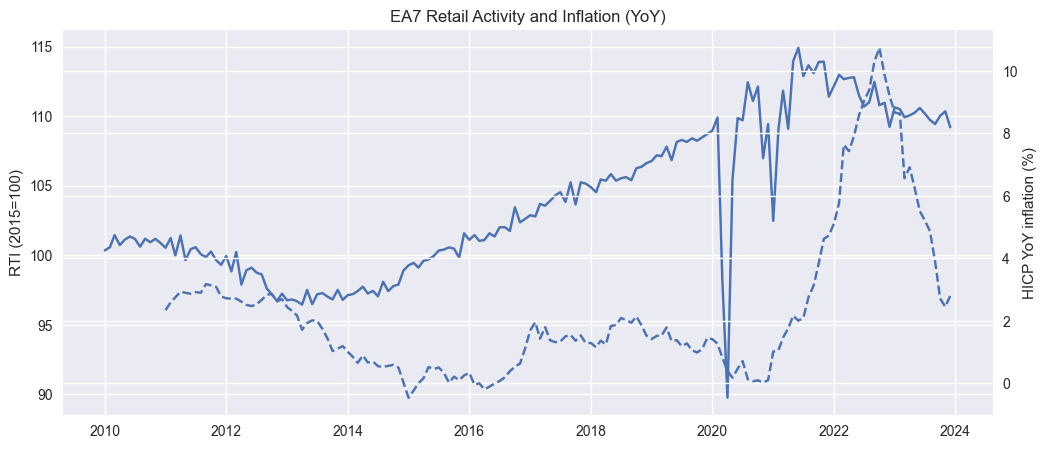

In [6]:
fig, ax1 = plt.subplots(figsize=(12,5))

ax1.plot(ea7["month_dt"], ea7["ea7_rti"], label="EA7 RTI")
ax1.set_ylabel("RTI (2015=100)")
ax1.set_xlabel("")

ax2 = ax1.twinx()
ax2.plot(ea7["month_dt"], ea7["ea7_hicp_yoy"], linestyle="--", label="EA7 HICP YoY")
ax2.set_ylabel("HICP YoY inflation (%)")

ax1.set_title("EA7 Retail Activity and Inflation (YoY)")
plt.show()

### Interpretation: RTI vs Inflation

This plot helps visually assess whether inflationary episodes coincide with:
- retail slowdowns (possible real-income squeeze),
- or retail strength (nominal effects / post-shock rebounds).

Important caution:
- RTI is a **volume index** (real activity), while inflation is price growth.
So negative co-movement is economically plausible.

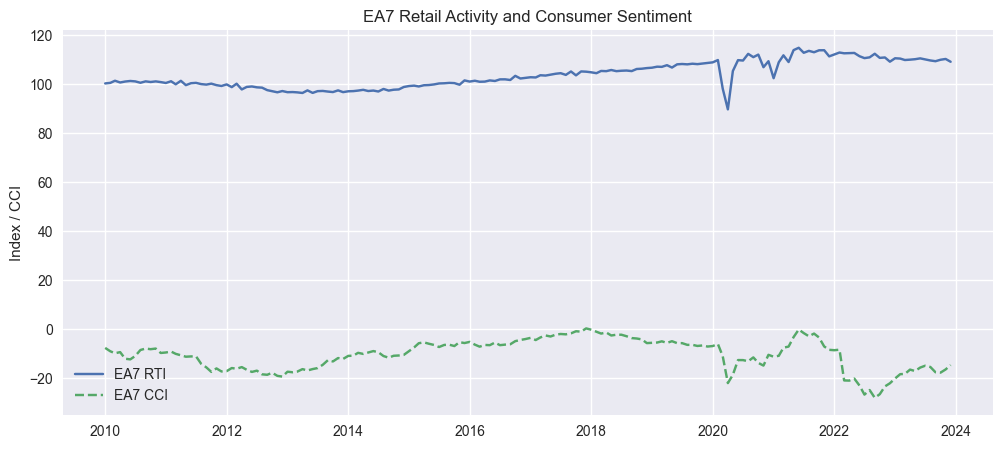

In [7]:
plt.figure(figsize=(12,5))
plt.plot(ea7["month_dt"], ea7["ea7_rti"], label="EA7 RTI")
plt.plot(ea7["month_dt"], ea7["ea7_cci"], label="EA7 CCI", linestyle="--")
plt.title("EA7 Retail Activity and Consumer Sentiment")
plt.ylabel("Index / CCI")
plt.legend()
plt.show()

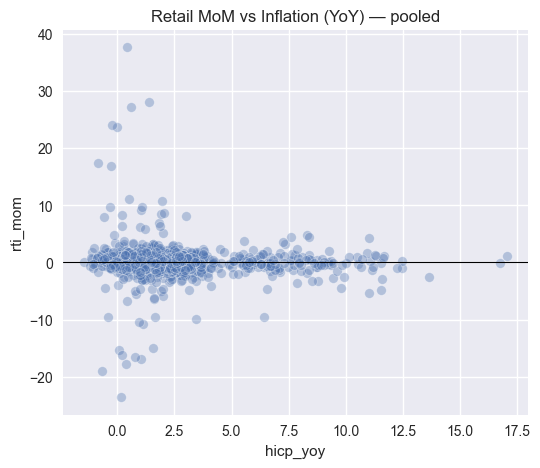

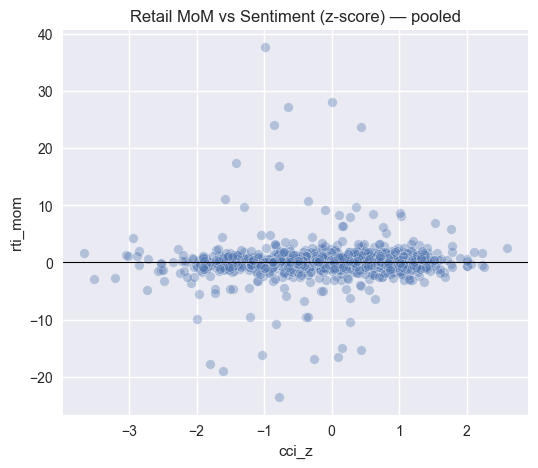

In [8]:
tmp = df.dropna(subset=["rti_mom","hicp_yoy","cci_z"])

plt.figure(figsize=(6,5))
sns.scatterplot(data=tmp, x="hicp_yoy", y="rti_mom", alpha=0.35)
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Retail MoM vs Inflation (YoY) — pooled")
plt.show()

plt.figure(figsize=(6,5))
sns.scatterplot(data=tmp, x="cci_z", y="rti_mom", alpha=0.35)
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Retail MoM vs Sentiment (z-score) — pooled")
plt.show()

In [9]:
corr_pooled = tmp[["rti_mom","hicp_yoy","cci_z"]].corr()
corr_pooled

,rti_mom,hicp_yoy,cci_z
rti_mom,1.000000,-0.053965,0.052826
hicp_yoy,-0.053965,1.000000,-0.534398
cci_z,0.052826,-0.534398,1.000000


In [10]:
corr_by_country = (
    tmp.groupby("country")[["rti_mom","hicp_yoy","cci_z"]]
       .corr()
)
corr_by_country

rti_mom  hicp_yoy     cci_z
country                                       
AT      rti_mom   1.000000 -0.050220  0.024800
        hicp_yoy -0.050220  1.000000 -0.736123
        cci_z     0.024800 -0.736123  1.000000
DE      rti_mom   1.000000 -0.083917  0.105592
        hicp_yoy -0.083917  1.000000 -0.741910
        cci_z     0.105592 -0.741910  1.000000
ES      rti_mom   1.000000 -0.031929  0.027519
        hicp_yoy -0.031929  1.000000 -0.391124
        cci_z     0.027519 -0.391124  1.000000
FI      rti_mom   1.000000 -0.138280  0.077660
        hicp_yoy -0.138280  1.000000 -0.558610
        cci_z     0.077660 -0.558610  1.000000
FR      rti_mom   1.000000 -0.055573  0.063619
        hicp_yoy -0.055573  1.000000 -0.397091
        cci_z     0.063619 -0.397091  1.000000
IT      rti_mom   1.000000 -0.068776  0.066093
        hicp_yoy -0.068776  1.000000 -0.268979
        cci_z     0.066093 -0.268979  1.000000
NL      rti_mom   1.000000 -0.044946  0.066857
        hicp_yoy -0.044946  1.000000 -0.673795
        cci_z     0.066857 -0.673795  1.000000

In [11]:
by_c = []
for c, g in tmp.groupby("country"):
    by_c.append({
        "country": c,
        "corr_rti_hicp": g["rti_mom"].corr(g["hicp_yoy"]),
        "corr_rti_cci": g["rti_mom"].corr(g["cci_z"]),
    })
pd.DataFrame(by_c).sort_values("corr_rti_hicp")

,country,corr_rti_hicp,corr_rti_cci
3,FI,-0.138280,0.077660
1,DE,-0.083917,0.105592
5,IT,-0.068776,0.066093
4,FR,-0.055573,0.063619
0,AT,-0.050220,0.024800
6,NL,-0.044946,0.066857
2,ES,-0.031929,0.027519


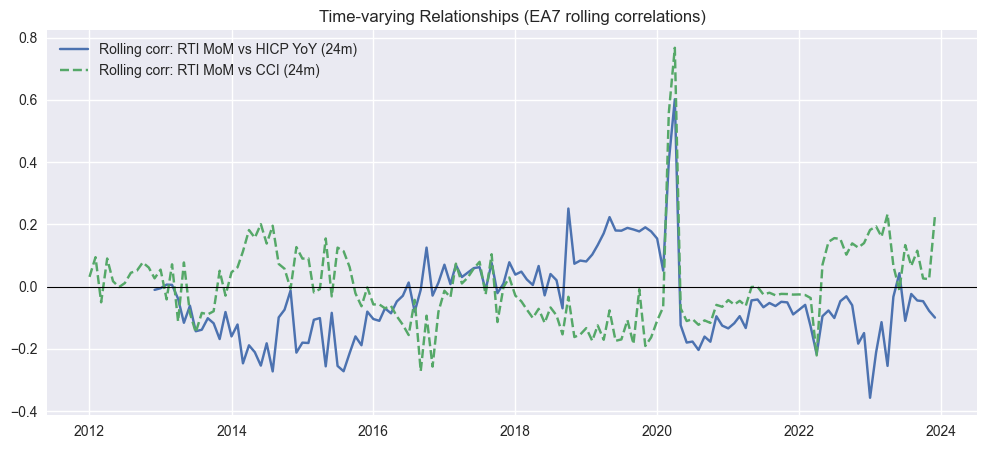

In [12]:
roll = ea7.copy()
roll["roll_corr_rti_infl"] = (
    roll["ea7_rti_mom"].rolling(24).corr(roll["ea7_hicp_yoy"])
)
roll["roll_corr_rti_cci"] = (
    roll["ea7_rti_mom"].rolling(24).corr(roll["ea7_cci"])
)

plt.figure(figsize=(12,5))
plt.plot(roll["month_dt"], roll["roll_corr_rti_infl"], label="Rolling corr: RTI MoM vs HICP YoY (24m)")
plt.plot(roll["month_dt"], roll["roll_corr_rti_cci"], label="Rolling corr: RTI MoM vs CCI (24m)", linestyle="--")
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Time-varying Relationships (EA7 rolling correlations)")
plt.legend()
plt.show()

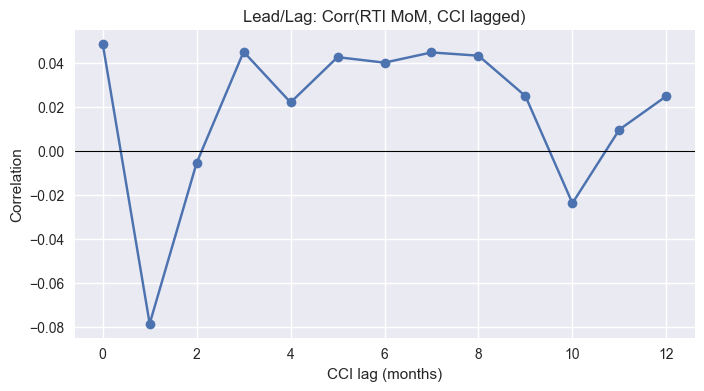

,lag_months,corr
0,0,0.048768
1,1,-0.078476
2,2,-0.005372
3,3,0.045092
4,4,0.022087
5,5,0.042659
6,6,0.040172
7,7,0.044805
8,8,0.043336
9,9,0.024978


In [13]:
def lag_corr(df_in, x, y, max_lag=12):
    out = []
    for L in range(0, max_lag+1):
        s = df_in.copy()
        s[f"{x}_lag{L}"] = s[x].shift(L)
        out.append((L, s[y].corr(s[f"{x}_lag{L}"])))
    return pd.DataFrame(out, columns=["lag_months", "corr"])

ea7_ll = ea7.dropna().copy()
ea7_ll["rti_mom"] = ea7_ll["ea7_rti"].pct_change() * 100
ea7_ll["cci"] = ea7_ll["ea7_cci"]

ll = lag_corr(ea7_ll, "cci", "rti_mom", max_lag=12)

plt.figure(figsize=(8,4))
plt.plot(ll["lag_months"], ll["corr"], marker="o")
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Lead/Lag: Corr(RTI MoM, CCI lagged)")
plt.xlabel("CCI lag (months)")
plt.ylabel("Correlation")
plt.show()

ll

In [14]:
reg = df.dropna(subset=["rti_mom","hicp_yoy","cci_z"]).copy()

# Country fixed effects
X = pd.get_dummies(reg["country"], drop_first=True)
X["hicp_yoy"] = reg["hicp_yoy"].values
X["cci_z"] = reg["cci_z"].values
X["const"] = 1.0

y = reg["rti_mom"].astype(float).values

# Force numeric matrix - convert all columns to float
X_mat = X[["const"] + [c for c in X.columns if c != "const"]].astype(float).values

# Ensure y is also float and convert to numpy array explicitly
y_array = np.asarray(y, dtype=float)

beta = np.linalg.lstsq(X_mat, y_array, rcond=None)[0]

coef = pd.Series(
    beta,
    index=["const"] + [c for c in X.columns if c != "const"]
)

coef[["hicp_yoy","cci_z"]]

hicp_yoy   -0.043883
cci_z       0.104862
dtype: float64

### Fixed-effects check (interpretation)

This is not a full econometric model, but it answers:

- After controlling for persistent country differences,
  does inflation relate to monthly retail changes?
- Does sentiment still matter?

We treat this as a *directional robustness check*, not causal inference.

Next extensions (optional):
- add lags (CCI_{t-1}, inflation_{t-1})
- add time fixed effects (month dummies)
- model in levels (RTI) with error-correction logic

## Summary

This notebook:
- Constructed RTI growth and inflation (YoY) measures
- Visualised retail vs inflation and sentiment
- Measured pooled and country-level correlations
- Showed time-varying relationships via rolling correlations
- Tested directional robustness with country fixed effects

Next: build a coherent "macro story" across shocks and regimes,
and define an analysis-ready set of figures/tables for the README.